# **Step 1 | Python Library**

In [1]:
! pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


## **1.1 | Import Libraries**

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
import pathlib
import glob
import shutil
from zipfile import ZipFile
from IPython.display import FileLink

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Layer, Flatten, Dense, Activation, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

import os
import json
import random
import warnings
import itertools
warnings.filterwarnings('ignore')

# **Step 2 | Data**

## **2.1 | Count Data and Classes**

In [3]:
path = '/kaggle/input/momee-dataset/momee_dataset/train'

class_names = sorted(os.listdir(path))
n_classes = len(class_names)
print(f"Class Names: \n{class_names}")
print(f"Total Number of Classes : {n_classes}")

Class Names: 
['baby_bed', 'baby_car_seat', 'baby_folding_fence', 'bathtub', 'booster_seats', 'bouncer', 'breast_pump', 'carrier', 'earmuffs', 'ride_ons', 'rocking_horse', 'sterilizer', 'stroller', 'walkers']
Total Number of Classes : 14


In [4]:
class_dis = [len(os.listdir(path + f"/{name}")) for name in class_names]
print(f"Class Distribution : \n{class_dis}")

Class Distribution : 
[1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]


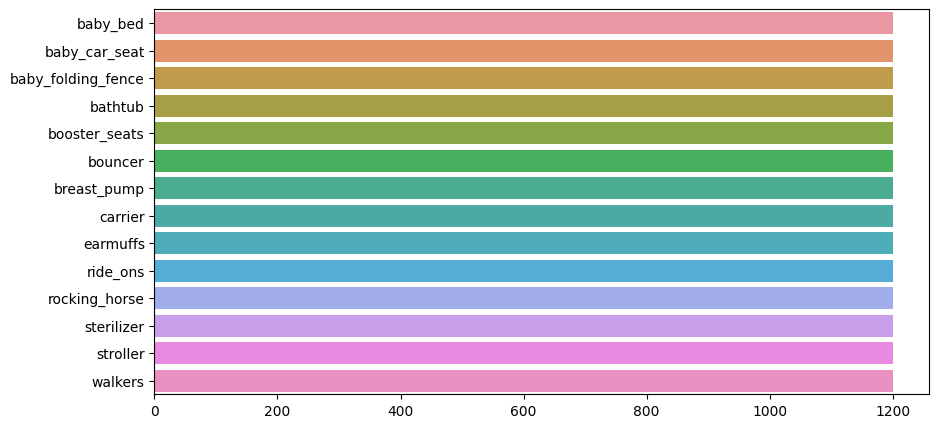

In [5]:
plt.figure(figsize=(10,5))
sns.barplot(y=class_names, x=class_dis, orient='h')
plt.xticks()
plt.show()

In [6]:
path = '/kaggle/input/momee-dataset/momee_dataset/val'

class_names = sorted(os.listdir(path))
n_classes = len(class_names)

class_dis = [len(os.listdir(path + f"/{name}")) for name in class_names]
print(f"Class Distribution : \n{class_dis}")

Class Distribution : 
[300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300]


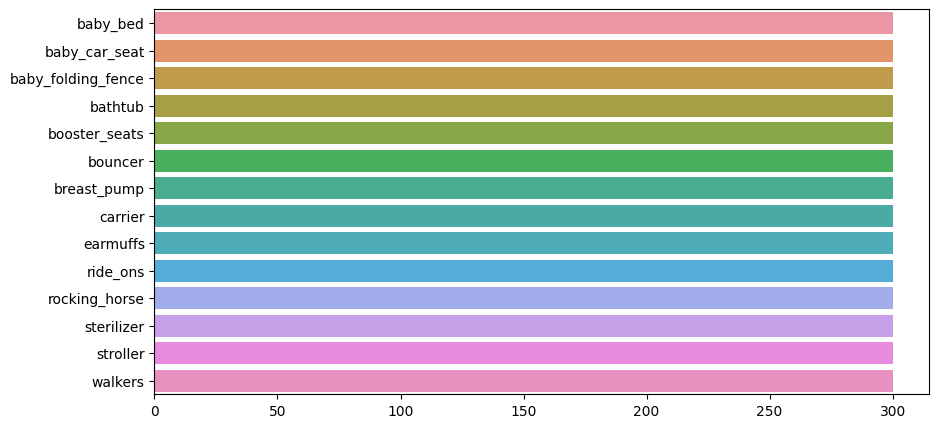

In [7]:
plt.figure(figsize=(10,5))
sns.barplot(y=class_names, x=class_dis, orient='h')
plt.xticks()
plt.show()

## **2.2 | Data Generator**

In [8]:
train_dir='/kaggle/input/momee-dataset/momee_dataset/train'
validation_dir='/kaggle/input/momee-dataset/momee_dataset/val'

train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                   zoom_range=0.2,
                                   rotation_range=20,
                                   brightness_range=[0.2,1.0],
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (224, 224),
                                                    batch_size = 32,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size = (224, 224),
                                                              batch_size = 32, 
                                                              class_mode='categorical',
                                                              shuffle=False)

Found 16800 images belonging to 14 classes.
Found 4200 images belonging to 14 classes.


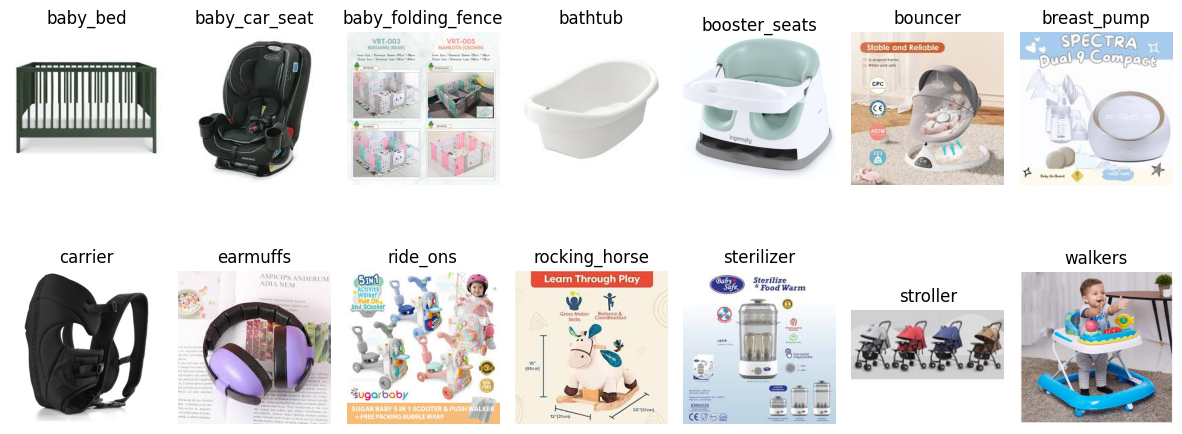

In [9]:
def show_image_per_class(directory, classes):
    num_classes = len(classes)
    num_rows = 7
    num_cols = 7

    plt.figure(figsize=(15, num_rows * 3))
    for i, class_name in enumerate(classes[:num_rows * num_cols]):
        class_dir = os.path.join(directory, class_name)
        img_file = random.choice(os.listdir(class_dir))
        img_path = os.path.join(class_dir, img_file)
        img = plt.imread(img_path)
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    
    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    plt.show()

show_image_per_class(train_dir, class_names)


In [10]:
def Show_Images(target_gen):
    batch_images, batch_labels = next(target_gen)

    class_labels = list(target_gen.class_indices.keys())

    plt.figure(figsize=(20, 20))
    for n, i in enumerate(list(np.random.randint(0, len(batch_images), 16))):
        plt.subplot(4, 4, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])
        plt.axis('off')
    plt.show()

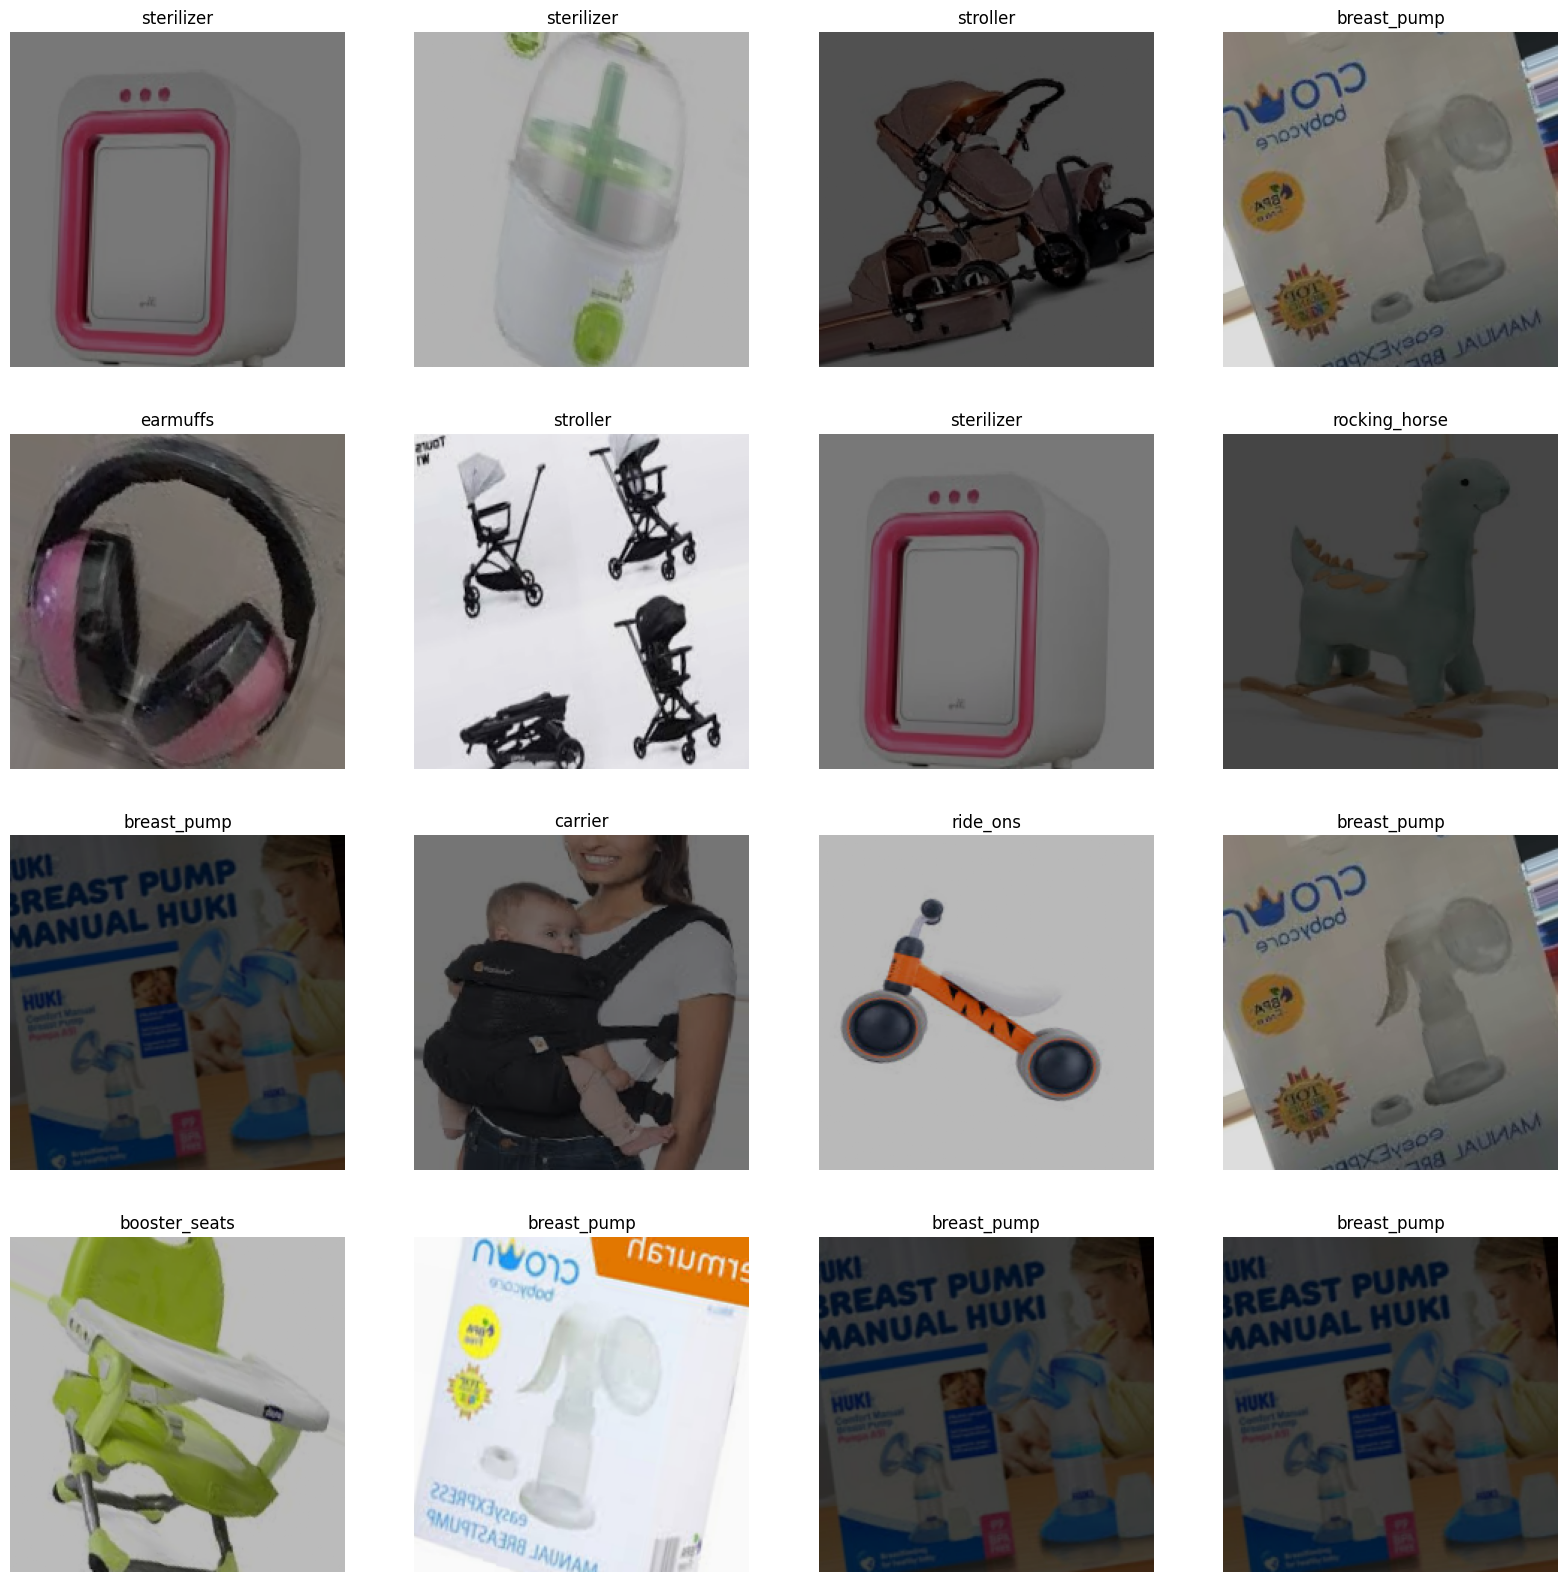

In [11]:
Show_Images(train_generator)

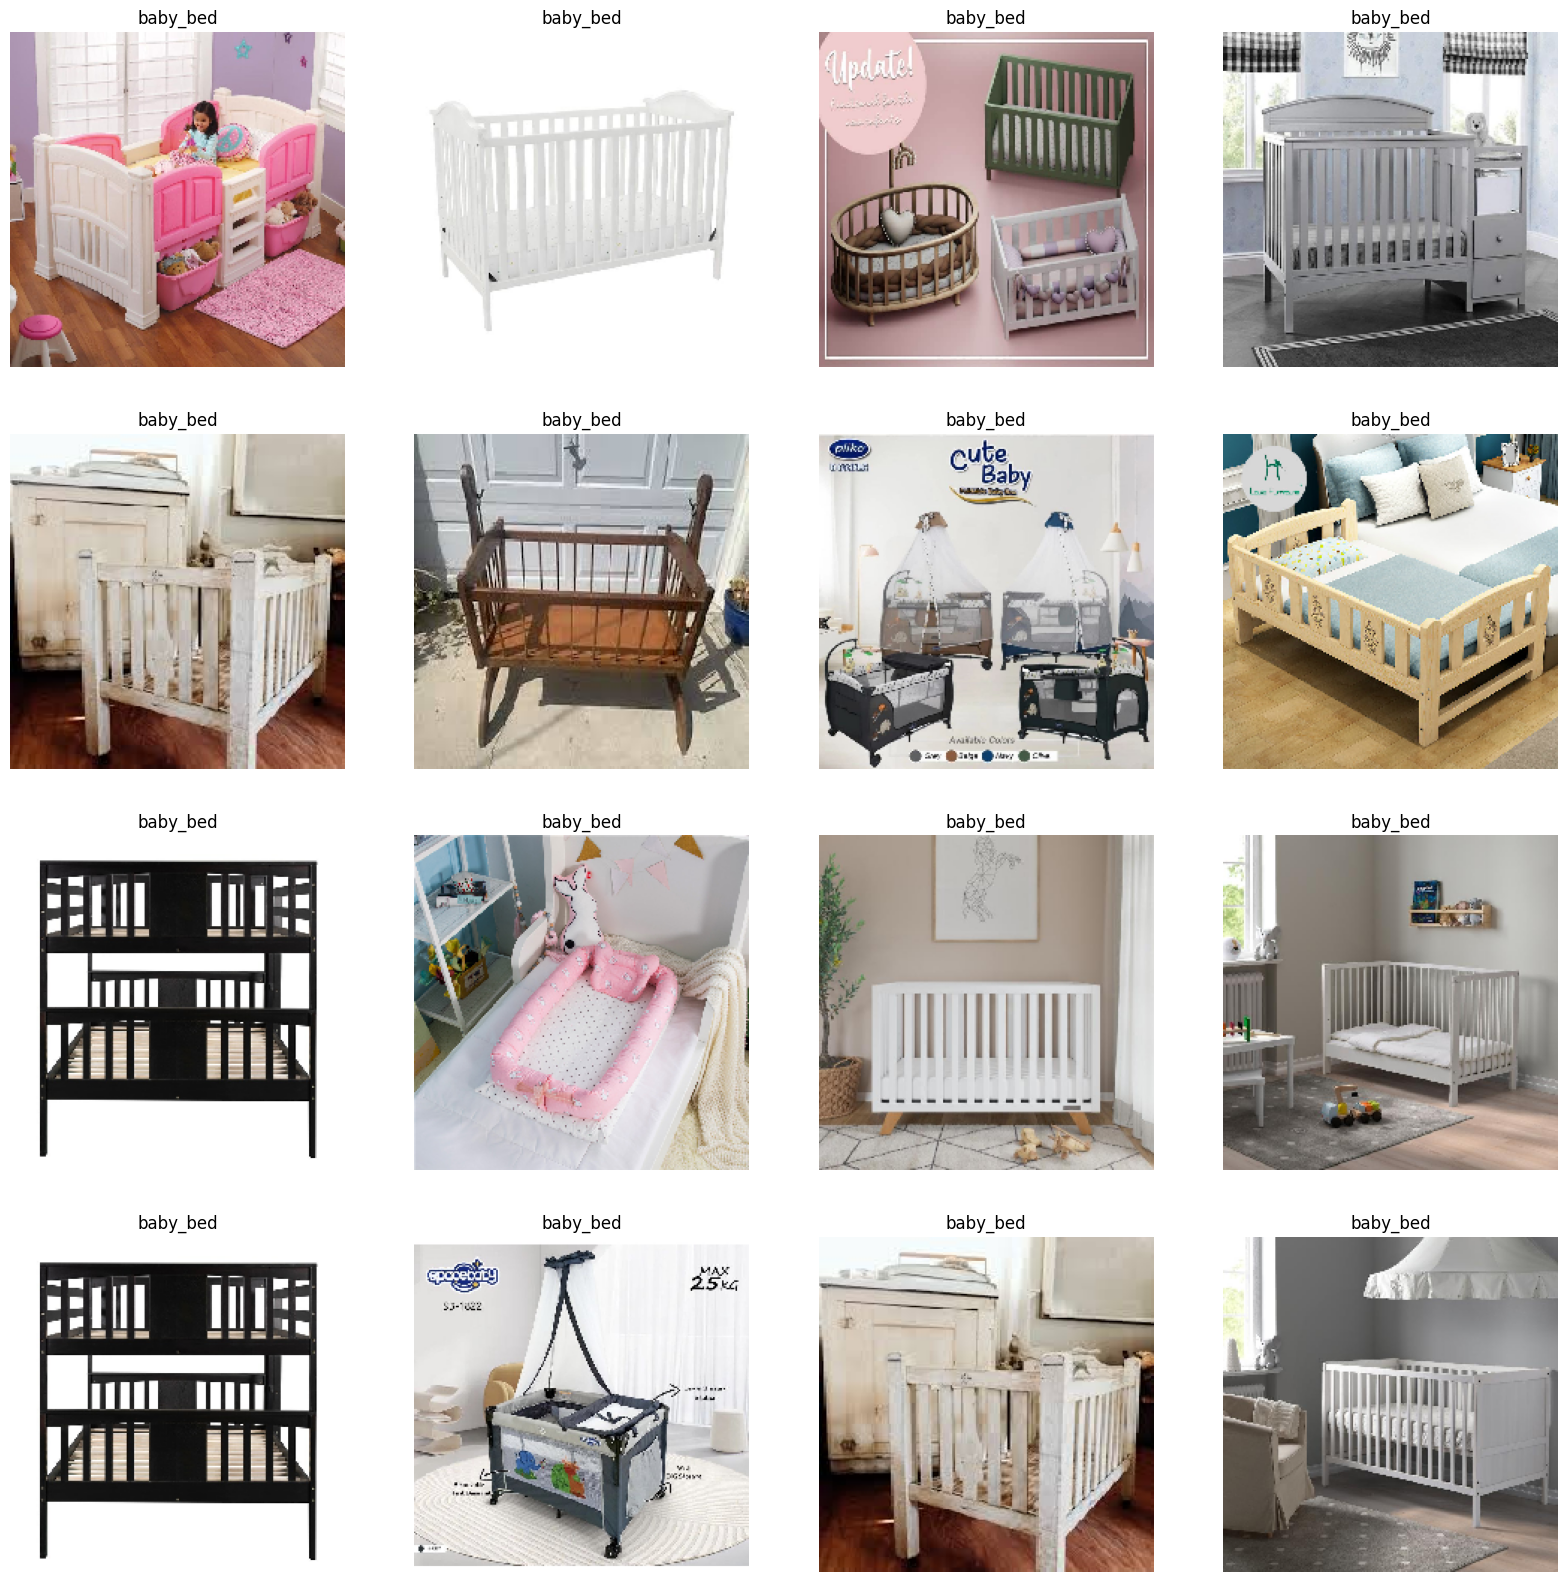

In [12]:
Show_Images(validation_generator)

# **Step 3 | Modelling**

## **3.1 | Add MobileNetV2 Model**

In [13]:
pre_trained_model = MobileNetV2(weights="imagenet",
                                include_top=False,
                                input_tensor=Input(shape=(224, 224, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

model = Sequential()
model.add(pre_trained_model)
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten(name="flatten"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dense(14, activation='softmax'))

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 128)         1474688   
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 128)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                           

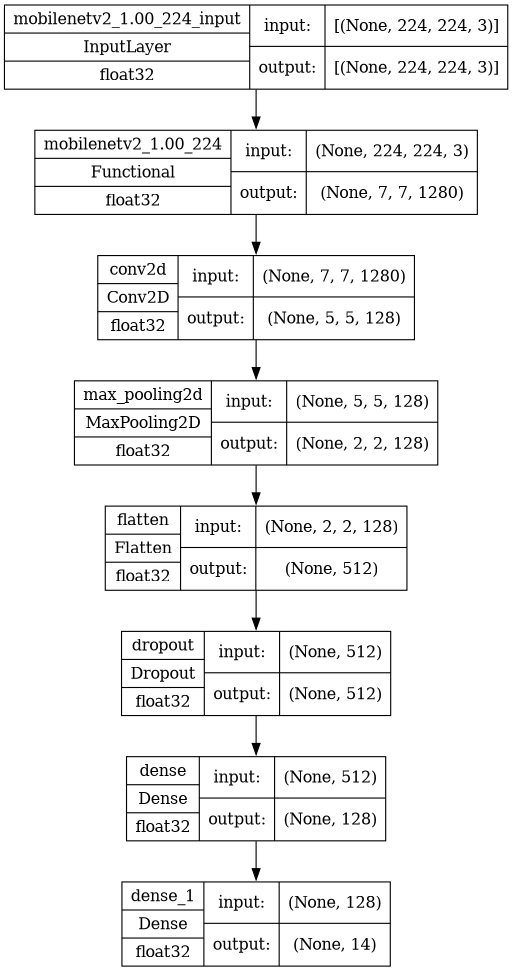

In [14]:
tf.keras.utils.plot_model(model,
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          show_dtype=True,dpi=80)

In [15]:
from keras.callbacks import ModelCheckpoint
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.96 and logs.get('accuracy') > 0.94:
      print('\nFor Epoch', epoch, '\nAccuracy has reach = %2.2f%%' %(logs['accuracy']*100), 'training has been stopped.')
      self.model.stop_training=True

callback=myCallback()

In [16]:
model_name = "model_checkpoint.h5"

checkpoint = ModelCheckpoint(model_name,
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only=True,
                             verbose=1)

In [17]:
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              patience=3, 
                              factor=0.5,
                              min_lr=1e-6)

In [18]:
num_epochs = 60

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = num_epochs,
                    verbose = 1,
                    callbacks = [callback, checkpoint, reduce_lr])

Epoch 1/60


I0000 00:00:1717145784.733814     130 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


525/525 [==============================] - ETA: 0s - loss: 0.9607 - accuracy: 0.7226
Epoch 1: val_accuracy improved from -inf to 0.87262, saving model to model_checkpoint.h5
525/525 [==============================] - 340s 632ms/step - loss: 0.9607 - accuracy: 0.7226 - val_loss: 0.4076 - val_accuracy: 0.8726 - lr: 0.0010
Epoch 2/60
525/525 [==============================] - ETA: 0s - loss: 0.6074 - accuracy: 0.8179
Epoch 2: val_accuracy did not improve from 0.87262
525/525 [==============================] - 257s 490ms/step - loss: 0.6074 - accuracy: 0.8179 - val_loss: 0.4836 - val_accuracy: 0.8583 - lr: 0.0010
Epoch 3/60
525/525 [==============================] - ETA: 0s - loss: 0.5120 - accuracy: 0.8495
Epoch 3: val_accuracy improved from 0.87262 to 0.89952, saving model to model_checkpoint.h5
525/525 [==============================] - 257s 490ms/step - loss: 0.5120 - accuracy: 0.8495 - val_loss: 0.3522 - val_accuracy: 0.8995 - lr: 0.0010
Epoch 4/60
525/525 [===========================

## **3.2 | Plot the Result of Training**

In [19]:
training_history = history.history
training_df = pd.DataFrame(training_history)
print(training_df.tail())

        loss  accuracy  val_loss  val_accuracy        lr
22  0.136018  0.956786  0.228585      0.936190  0.000125
23  0.135606  0.956607  0.232138      0.935238  0.000125
24  0.135559  0.956964  0.222045      0.938571  0.000125
25  0.128789  0.956964  0.218229      0.940238  0.000125
26  0.123405  0.960774  0.225668      0.938810  0.000125


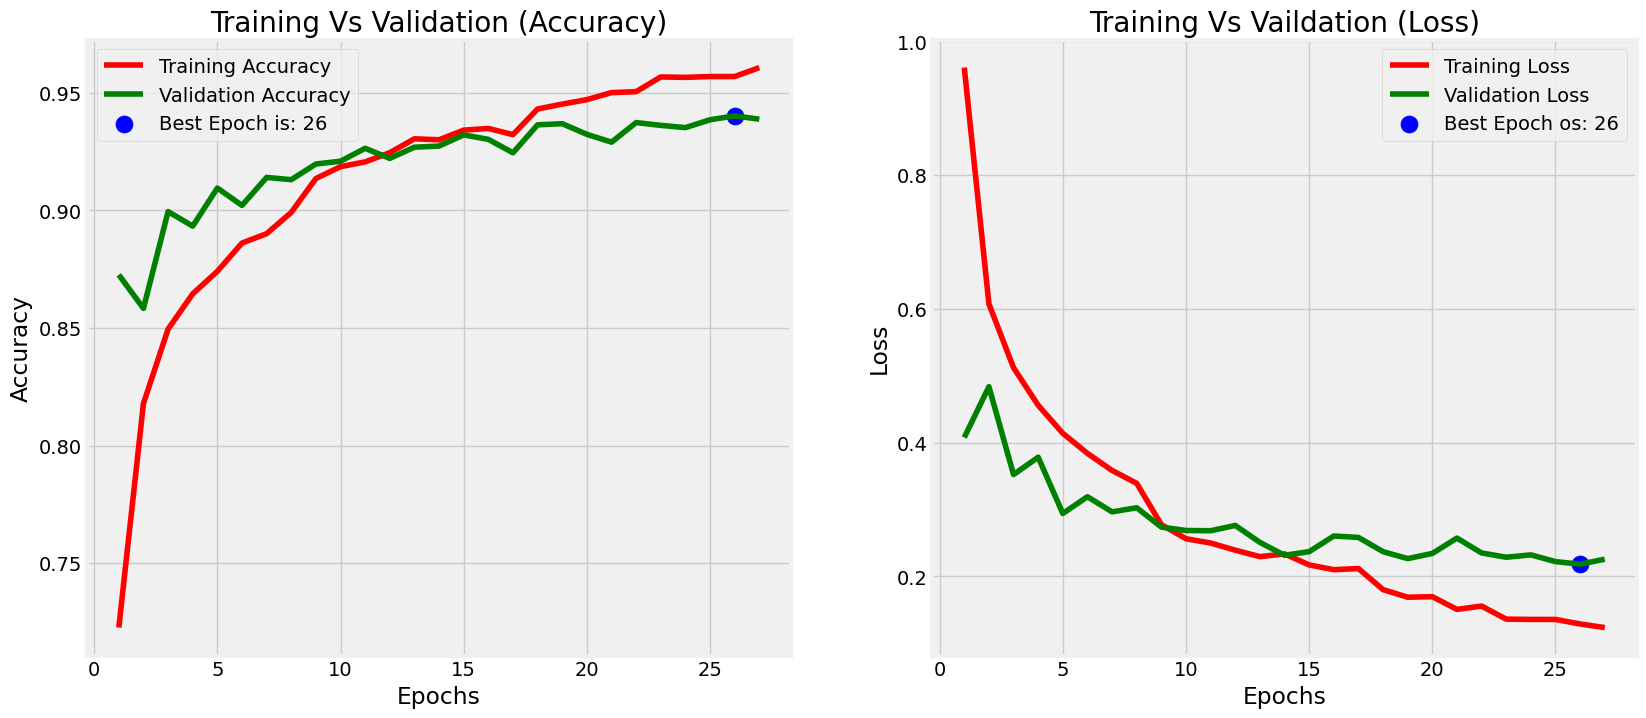

In [20]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc= np.argmax(val_acc)

val_lowest= val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs= [i+1 for i in range(len(train_acc))]
acc_label = f"Best Epoch is: {str(index_acc +1)}"
loss_label = f"Best Epoch os: {str(index_loss +1)}"

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_acc , 'r' , label= "Training Accuracy")
plt.plot(epochs , val_acc , 'g' , label= "Validation Accuracy")
plt.scatter(index_acc +1 ,val_highest , s = 150 , c= 'blue', label= acc_label)
plt.title('Training Vs Validation (Accuracy)')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_loss , 'r' , label= "Training Loss")
plt.plot(epochs , val_loss , 'g' , label= "Validation Loss")
plt.scatter(index_loss +1 , val_lowest , s= 150 , c = 'blue' , label= loss_label)
plt.title("Training Vs Vaildation (Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout
plt.show();

## **3.3 | Model Evaluation**

In [21]:
score, acc = model.evaluate(train_generator)
print('Train Accuracy =', acc)
print('Train Loss =', score)

print('=' * 50)

score, acc = model.evaluate(validation_generator)
print('Validation Accuracy =', acc)
print('Validation Loss =', score)

525/525 [==============================] - 236s 449ms/step - loss: 0.0989 - accuracy: 0.9699
Train Accuracy = 0.9699404835700989
Train Loss = 0.09894957393407822
132/132 [==============================] - 13s 98ms/step - loss: 0.2257 - accuracy: 0.9388
Validation Accuracy = 0.9388095140457153
Validation Loss = 0.22566810250282288


## **3.4 | Model Prediction**

### **1. Confution Matrix**

132/132 [==============================] - 14s 100ms/step


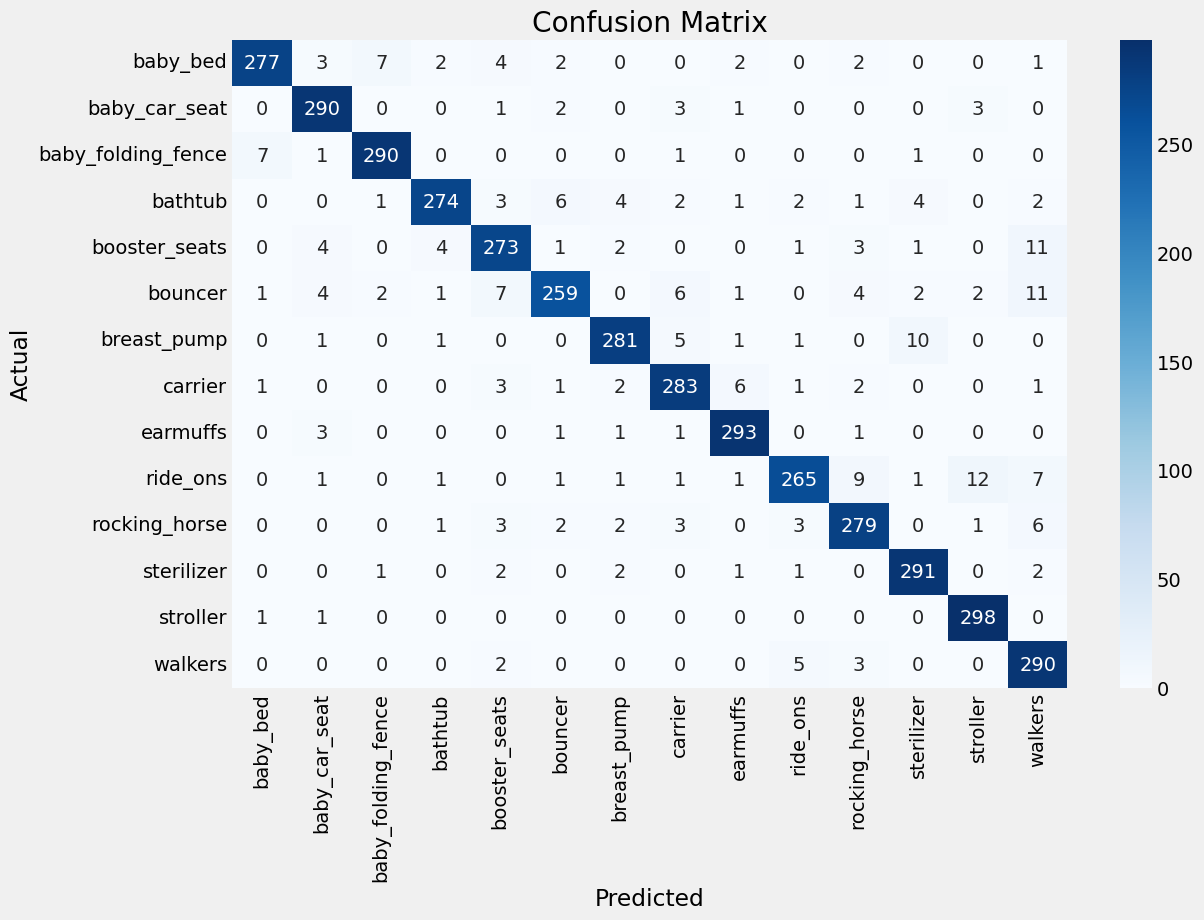

In [22]:
# Reset the validation generator
validation_generator.reset()

# Generate predictions
Y_pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plot confusion matrix with rotated x-axis labels
plt.figure(figsize=(12, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap='Blues')
plt.xticks(rotation=90)  # Rotate x-axis tick labels by 45 degrees
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

### **2. Classification Report**

In [23]:
y_val = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred,axis=1)

132/132 [==============================] - 14s 102ms/step


In [24]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       300
           1       0.94      0.97      0.95       300
           2       0.96      0.97      0.97       300
           3       0.96      0.91      0.94       300
           4       0.92      0.91      0.91       300
           5       0.94      0.86      0.90       300
           6       0.95      0.94      0.94       300
           7       0.93      0.94      0.94       300
           8       0.95      0.98      0.97       300
           9       0.95      0.88      0.92       300
          10       0.92      0.93      0.92       300
          11       0.94      0.97      0.95       300
          12       0.94      0.99      0.97       300
          13       0.88      0.97      0.92       300

    accuracy                           0.94      4200
   macro avg       0.94      0.94      0.94      4200
weighted avg       0.94      0.94      0.94      4200



### **3. Image Prediction Visualization**

In [25]:
class_indices = validation_generator.class_indices
indices = {v:k for k,v in class_indices.items()}

In [26]:
filenames = validation_generator.filenames

In [27]:
val_df = pd.DataFrame()
val_df['filename'] = filenames
val_df['actual'] = y_val
val_df['predicted'] = y_pred
val_df['actual'] = val_df['actual'].apply(lambda x: indices[x])
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x])
val_df.loc[val_df['actual']==val_df['predicted'],'Same'] = True
val_df.loc[val_df['actual']!=val_df['predicted'],'Same'] = False
val_df.head(10)

filename    actual predicted  Same
0    baby_bed/baby_bed1.jpg  baby_bed  baby_bed  True
1   baby_bed/baby_bed10.jpg  baby_bed  baby_bed  True
2  baby_bed/baby_bed100.jpg  baby_bed  baby_bed  True
3  baby_bed/baby_bed101.jpg  baby_bed  baby_bed  True
4  baby_bed/baby_bed102.jpg  baby_bed  baby_bed  True
5  baby_bed/baby_bed103.jpg  baby_bed  baby_bed  True
6  baby_bed/baby_bed104.jpg  baby_bed  baby_bed  True
7  baby_bed/baby_bed105.jpg  baby_bed  baby_bed  True
8  baby_bed/baby_bed106.jpg  baby_bed  baby_bed  True
9  baby_bed/baby_bed107.jpg  baby_bed  baby_bed  True

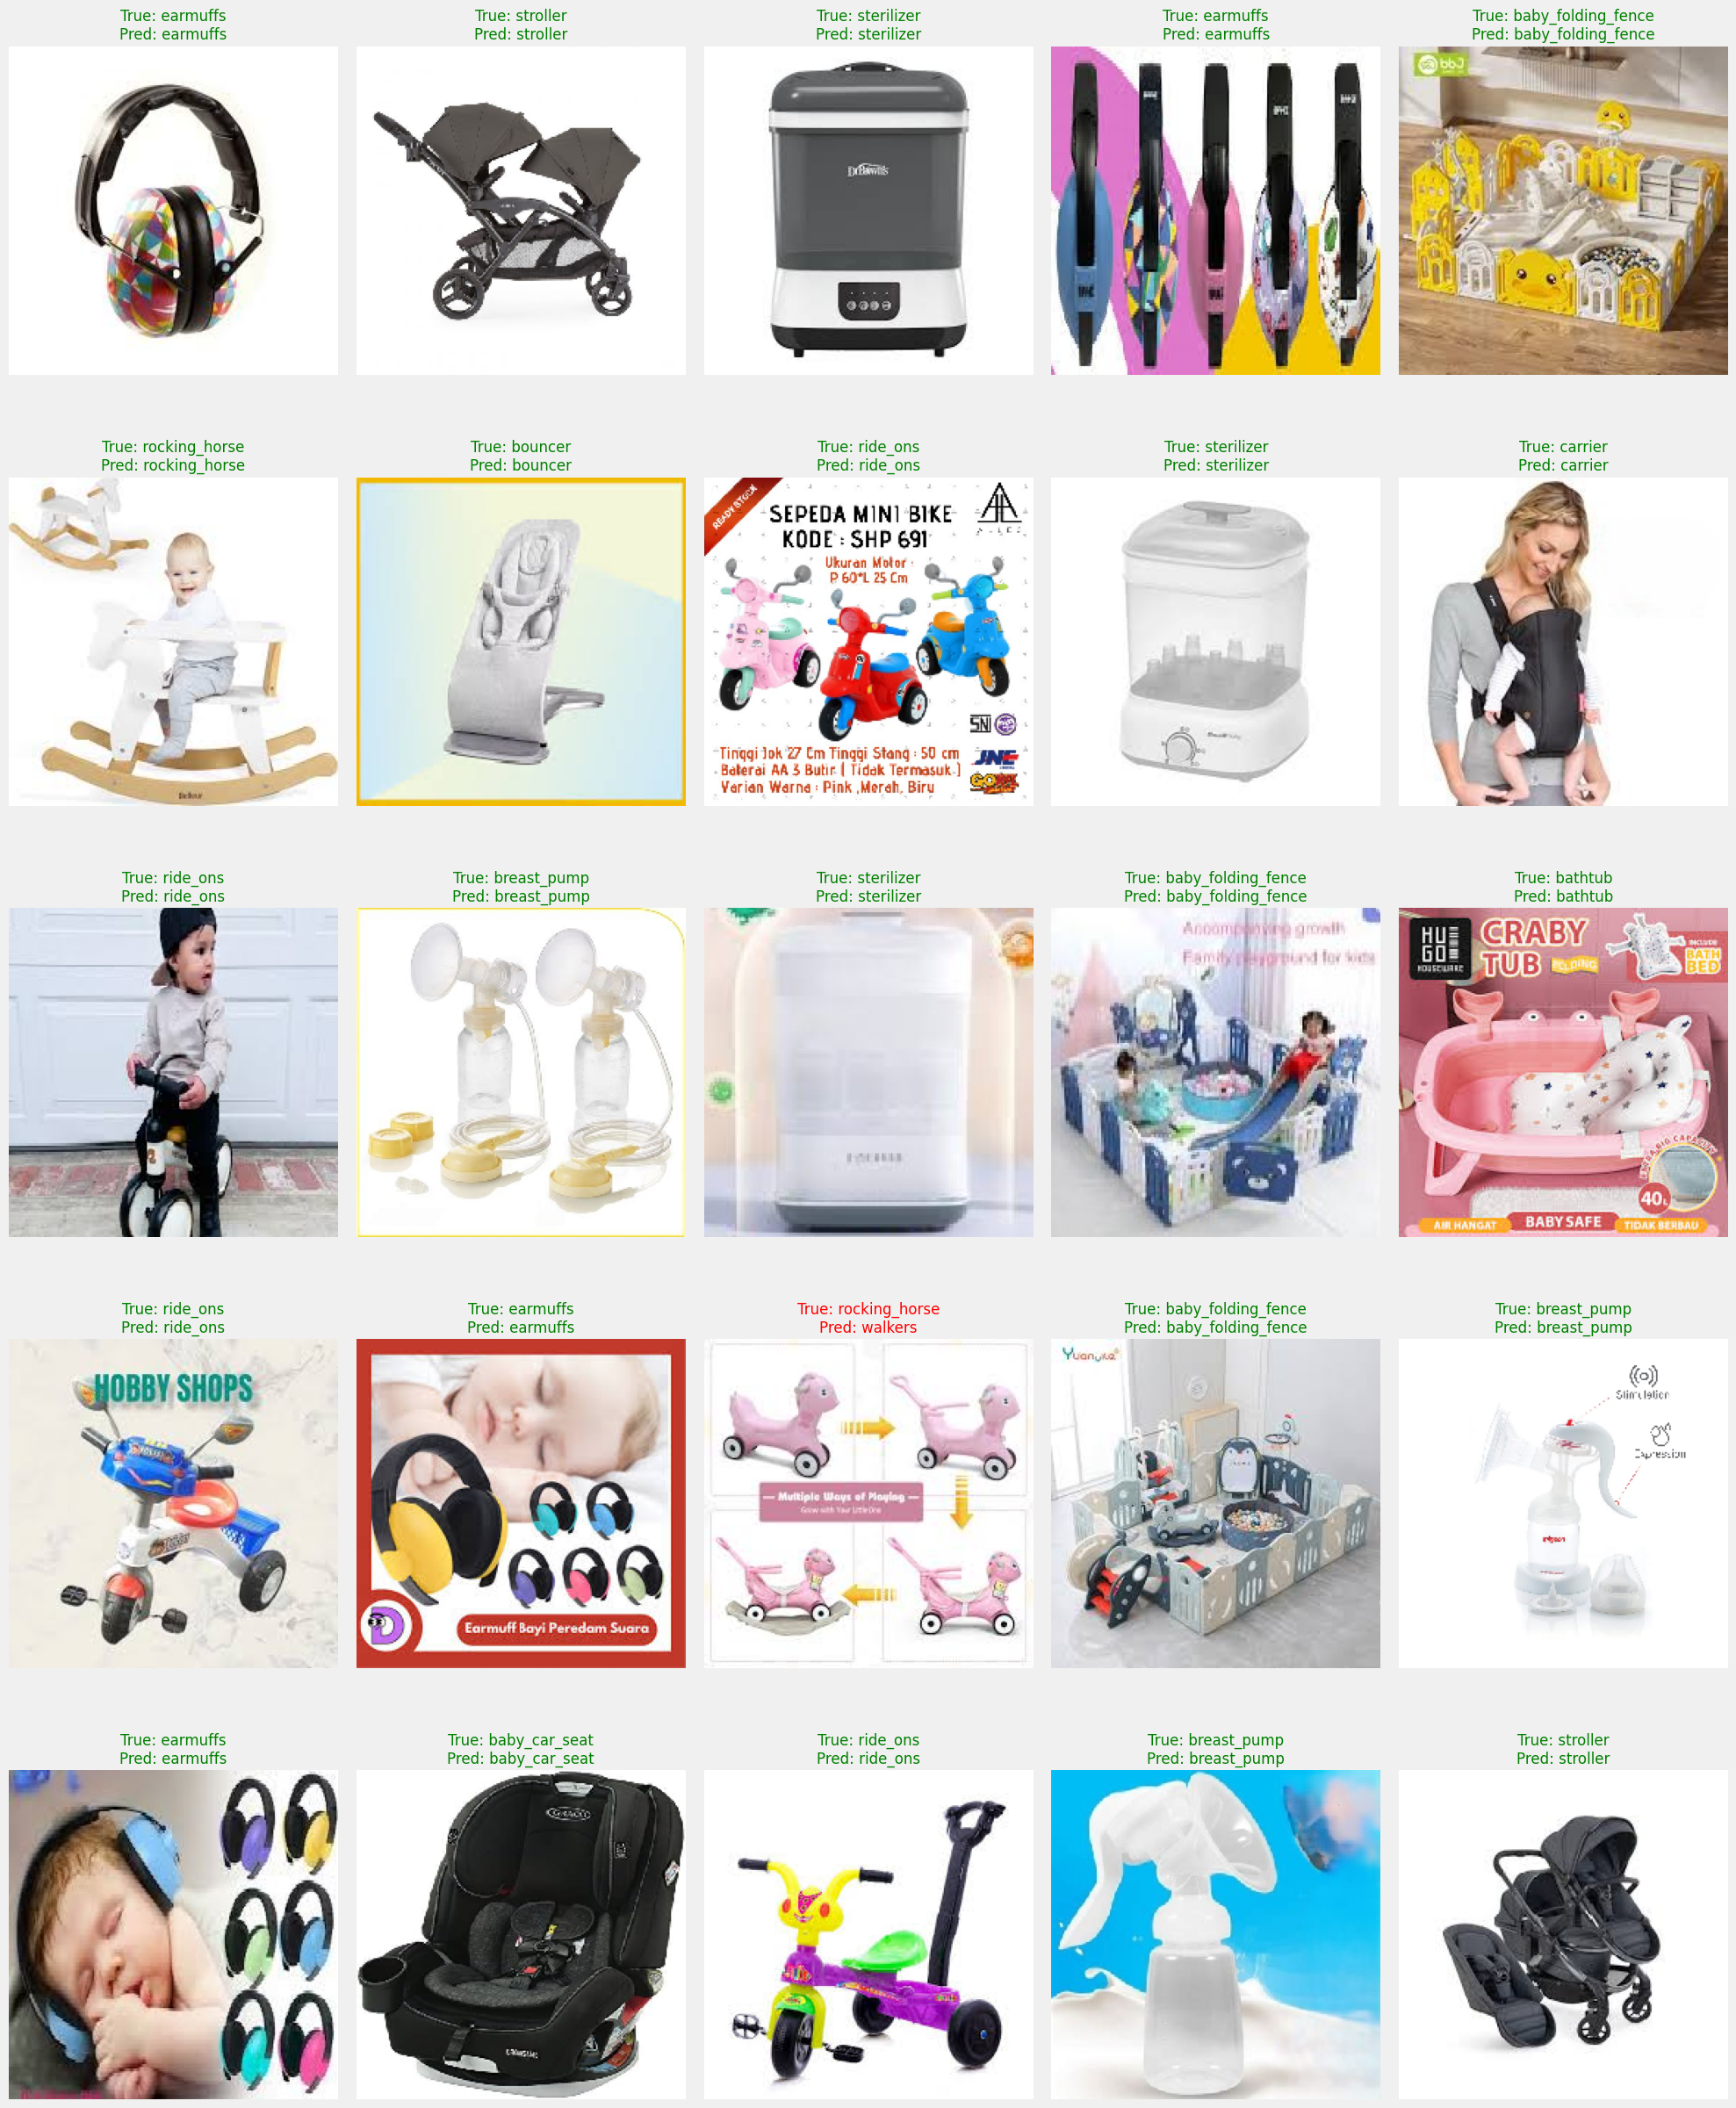

In [28]:
def plot_images(val_df, path, num_images=50):
    fig, axes = plt.subplots(5, num_images // 10, figsize=(20, 25))
    axes = axes.flatten()

    sample_df = val_df.sample(num_images)
    for ax, (_, row) in zip(axes, sample_df.iterrows()):
        img_path = os.path.join(path, row['filename'])
        img = load_img(img_path, target_size=(224, 224))
        img = img_to_array(img) / 255.0

        ax.imshow(img)
        ax.axis('off')
        title = f"True: {row['actual']}\nPred: {row['predicted']}"
        ax.set_title(title, fontsize=12, color="green" if row['Same'] else "red")

    plt.tight_layout()
    plt.show()

# Plot 50 images
plot_images(val_df, path, num_images=50)

# **Step 4 | Convert Model**

## **4.1 | Convert to TFJS**

In [35]:
model.save("model_tf.h5")

In [36]:
!pip install tensorflowjs
 
!tensorflowjs_converter --input_format=keras model_tf.h5 tfjs_model

2024-05-31 11:13:09.315036: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 11:13:09.315094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 11:13:09.316537: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [37]:
shutil.make_archive('/kaggle/working/tfjs_model', 'zip', '/kaggle/working/tfjs_model')

FileLink(r'/kaggle/working/tfjs_model.zip')

/kaggle/working/tfjs_model.zip

## **4.2 | Convert to TF-Serving**

In [41]:
# Define the class names in order
class_names = class_names

# Create a dictionary mapping class indices to class names
label_mapping = {str(i): class_name for i, class_name in enumerate(class_names)}

# Path to save the label mapping file
label_mapping_path = "/kaggle/working/label_mapping.json"

# Save the label mapping to a JSON file
with open(label_mapping_path, 'w') as f:
    json.dump(label_mapping, f)

print(f"Label mapping saved to {label_mapping_path}")

# Path where we will save the model
saved_model_path = "/kaggle/working/models/rps_model/1"

# Save the model in TensorFlow Serving format
model.save(saved_model_path, save_format='tf')

print(f"Model saved to {saved_model_path}")

# Path for the output zip file
zip_file_path = "/kaggle/working/saved_model.zip"

# Create a zip file with the models directory
shutil.make_archive("/kaggle/working/saved_model", 'zip', "/kaggle/working/models")

# Add the label mapping file to the zip file
with ZipFile(zip_file_path, 'a') as zipf:
    zipf.write(label_mapping_path, os.path.basename(label_mapping_path))

print(f"Model and label mapping zipped at {zip_file_path}")

Label mapping saved to /kaggle/working/label_mapping.json
Model saved to /kaggle/working/models/rps_model/1
Model and label mapping zipped at /kaggle/working/saved_model.zip


## **4.2 | Convert to TF-Lite**

In [40]:
# Path to the model to be converted
model_path = '/kaggle/working/model_tf.h5'

# Load the Keras model
model = tf.keras.models.load_model(model_path)

# Function to generate representative data
def representative_data_gen():
    for input_value, _ in itertools.islice(train_generator, 20):
        yield [input_value]

# Define label mapping
label_mapping = class_names

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Configure conversion options
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_data_gen

# Convert the model to TFLite format
tflite_model = converter.convert()

# Save the TFLite model to disk
tflite_model_path = '/kaggle/working/converted_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Print the label mapping
print("Label Mapping:")
for index, class_name in enumerate(label_mapping):
    print(f"{index} -> {class_name}")

print("Model conversion to TFLite completed.")

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 112, Total Ops 187, % non-converted = 59.89 %
 * 112 ARITH ops

- arith.constant:  112 occurrences  (f32: 110, i32: 2)



  (f32: 10)
  (f32: 36)
  (f32: 17)
  (f32: 2)
  (f32: 1)
  (f32: 4)
  (f32: 1)
  (f32: 1)
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


Label Mapping:
0 -> baby_bed
1 -> baby_car_seat
2 -> baby_folding_fence
3 -> bathtub
4 -> booster_seats
5 -> bouncer
6 -> breast_pump
7 -> carrier
8 -> earmuffs
9 -> ride_ons
10 -> rocking_horse
11 -> sterilizer
12 -> stroller
13 -> walkers
Model conversion to TFLite completed.
